In [2]:
import numpy as np
import scipy

In [3]:
import pandas as pd

# Read the CSV file skipping the first row
df = pd.read_csv("data/202403_fitted_temperatures_vs_position.csv", header=None, skiprows=1)

# If you're not sure about the number of columns, you can loop through them
num_columns = len(df.columns)
columns = []

for i in range(num_columns):
    columns.append(df[i].values)
columns = np.asarray(columns)
# Now each column is stored in separate arrays, starting from the second row

The file is organized as column0=$\gamma$, column1=$\delta \gamma$, column2=laser source position (in micron), column3=temperatur (in Kelvin), column4=cryo temperature (in Kelvin)

In [4]:
gamma = columns[0]
dgamma = columns[1]
position = columns[2]
temp = columns[3]
cryotemp = columns[4]

In [5]:
#sort all the quantities ordered by cryo temperature
idx = np.argsort( cryotemp )
gamma = gamma[idx]
dgamma = dgamma[idx]
position = position[idx]
temp = temp[idx]
cryotemp = cryotemp[idx]

arg_n = 0
arr_X = []
arr_T = []
arr_cryoT = []
count = 0
for nc in range(cryotemp.size-1):
    
    if np.abs(cryotemp[nc] - cryotemp[nc+1]) > np.abs(cryotemp[nc])/100.:
        T = temp[arg_n : nc+1]
        X = position[arg_n : nc+1]
        #re-ordering from neg to pos position
        idx = np.argsort( X )
        X = X[idx]
        T = T[idx]
        
        arr_X.append( X )
        arr_T.append( T )
        arr_cryoT.append( cryotemp[arg_n] )
        count += 1
        arg_n = nc+1
    elif nc == cryotemp.size-2:
        T = temp[arg_n : nc+2]
        X = position[arg_n : nc+2]
        #re-ordering from neg to pos position
        idx = np.argsort( X )
        X = X[idx]
        T = T[idx]
        
        arr_X.append( X )
        arr_T.append( T )
        arr_cryoT.append( cryotemp[arg_n] )
        count += 1
arr_cryoT = np.asarray(arr_cryoT)
N_cryo = count

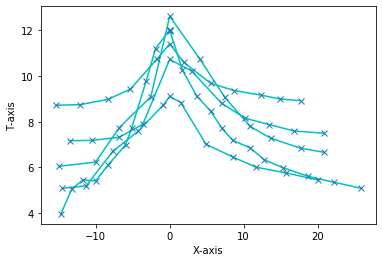

In [6]:
import matplotlib.pyplot as plt

for n in range(N_cryo):
    plt.plot( arr_X[n], arr_T[n], 'c')


Nc = columns[2].size
plt.plot( columns[2], columns[3], 'x')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('T-axis')

# Show plot
plt.show()

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import functions as fun
#Define the number of lattice sites on x and y
Nx = 50
Ny = 50
#=============================================
#Choose your lattice type
#pR = fun.triangular_lattice( Nx, Ny )
pR = fun.square_lattice( Nx, Ny )
#pR = fun.honeycomb_lattice( Nx, Ny )
#=============================================
#If you want hexagonal boundaries use this function. Otherwise comment it with '#' and set R=pR
R = pR
#R = fun.hexagonal_boundaries(pR)
#=============================================
#Dissipative boundaries
x = R[:,0]
y = R[:,1]
beta = 3.5
x0 = 5
y0 = 5
vec = (1./( np.exp( beta*(x-x0) ) + 1. ) + 1./( np.exp( -beta*(x-(Nx-1 - x0)) ) + 1. ) )*(1./( np.exp( -beta*(y-y0) ) + 1. ) + 1./( np.exp( beta*(y-(Ny-1 - y0)) ) + 1. ))
vec += (1./( np.exp( beta*(y-y0) ) + 1. ) + 1./( np.exp( -beta*(y-(Ny-1 - y0)) ) + 1. ) )*( 1./( np.exp( -beta*(x-x0) ) + 1. ) + 1./( np.exp( beta*(x-(Nx-1 - x0)) ) + 1. ) )
vec = (vec - np.amin(vec))/(np.amax(vec)- np.amin(vec)) * 10.
#=============================================
#Define the integral kernel that solve the heat equation (also called Green's function)
HeatKernel = fun.heat_kernel(R, vec)
#=============================================

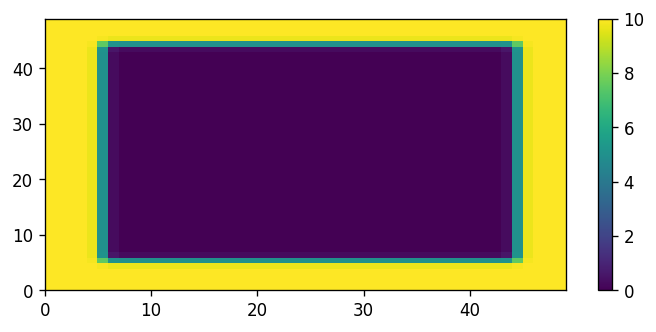

In [120]:
x, y = np.meshgrid( np.linspace(0, Nx-1, Nx), np.linspace(0, Ny-1, Ny)  )
vec = (1./( np.exp( beta*(x-x0) ) + 1. ) + 1./( np.exp( -beta*(x-(Nx-1 - x0)) ) + 1. ) )*(1./( np.exp( -beta*(y-y0) ) + 1. ) + 1./( np.exp( beta*(y-(Ny-1 - y0)) ) + 1. ))
vec += (1./( np.exp( beta*(y-y0) ) + 1. ) + 1./( np.exp( -beta*(y-(Ny-1 - y0)) ) + 1. ) )*( 1./( np.exp( -beta*(x-x0) ) + 1. ) + 1./( np.exp( beta*(x-(Nx-1 - x0)) ) + 1. ) )
vec = (vec - np.amin(vec))/(np.amax(vec)- np.amin(vec)) * 10.
fig, ax = plt.subplots(dpi=120, figsize=(7, 3))
pcm = ax.pcolormesh(x, y, np.abs(vec), cmap='viridis', shading='auto')
cbar = plt.colorbar(pcm, ax=ax)

plt.show()

In [152]:
from scipy.interpolate import interp1d
#kappa0 = 0.0084 #heat conductivity in W/(m K)
#T0 = 3. #reference temperature of the membrane in Kelvin
#P_L = 40 * 0.000000001 #in nWatts
#L_tot = Xmax-Xmin #characteristic system size in micron ... it should be something like L_tot > Nx, Ny

def temp_profile( arr_X, nu, kappa0, T0, X_meas, P_L, L_tot ):
    #Choose more or less (it will be approximated to the closest lattice site) 
    #a position on the lattice where you want to measure T (molecule position)
    #X_meas = np.amax(R[:,0])/2.
    Y_meas = np.amax(R[:,1])/2.
    #Choose a position along Y where to put your laser (the scan will be done along X)
    Y_L = np.amax(R[:,1])/2. #Here I set the laser around half-lattice on Y
    #=============================================
    #=============================================
    #Define dimensional parameters
    dr = L_tot/np.sqrt(Nx*Ny) #in micron
    #Define the main control parameter of the heat equation
    X0 = P_L/kappa0/T0 * 1000000 #in micron
    #=============================================
    #Choose the value of the laser spatial width (assuming a Gaussian profile for now, in adimensional units)
    sigma_L = 1. #in micron
    C = 4.*( np.abs(nu) + 1. ) * ( X0/dr )
    #=============================================
    #Make the laser scan along x solving iteratively the heat equation
    #arr_X stores the positions of the laser along X (given that it is in Y_L along Y)
    #T_meas stores the temperature profile as a function of the laser x-position
    #outputs are in ADIMENSIONAL units
    arr_X_discr, T_meas_discr = fun.x_laser_scan(R, HeatKernel, X_meas, Y_meas, Y_L, C, np.abs(nu), sigma_L/dr )
    #=============================================
    #Here we set everything in DIMENSIONAL units
    T_interp = interp1d(dr*arr_X_discr, T_meas_discr, kind='linear')
    T_meas = T0*T_interp(arr_X) 
    
    return T_meas

In [208]:
from scipy.optimize import curve_fit

n = 4
cryoT = arr_cryoT[n]

L_tot = (np.amax(arr_X[n])-np.amin(arr_X[n]))*1.5
print(L_tot)
P_L = 100 * 0.000000001 #in nWatts
X_meas = (10.)/(L_tot/np.sqrt(Nx*Ny)) + x0

funT = lambda arr_X, nu, kappa0, T0: temp_profile( arr_X, nu, kappa0, T0, X_meas, P_L, L_tot )

popt, pcov = curve_fit( funT, arr_X[n]-np.amin(arr_X[n]), arr_T[n], p0=[ 2.0, 0.008, cryoT ] )
#y_fit = funT(arr_X[n]-np.amin(arr_X[n]), popt[0], popt[1], popt[2], popt[3] )


49.61022472877674


In [209]:
print(popt)
vec_x = np.linspace( 0, np.amax(arr_X[n])-np.amin(arr_X[n]) , 100 )
y_fit = funT( vec_x, popt[0], popt[1], popt[2] )

[-9.22788216e-08  7.15065151e-02  8.70358350e+00]


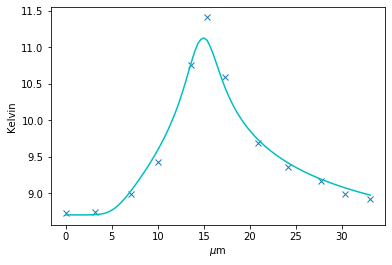

In [210]:
plt.plot( arr_X[n]-np.amin(arr_X[n]), arr_T[n], 'x')

plt.plot( vec_x, y_fit, 'c')

# Add labels and legend
plt.xlabel('$\mu$m')
plt.ylabel('Kelvin')

# Show plot
plt.show()

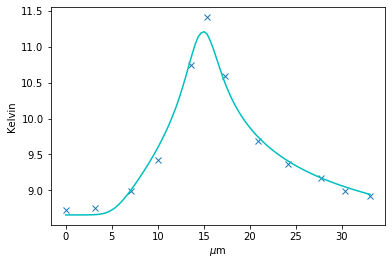

In [203]:
plt.plot( arr_X[n]-np.amin(arr_X[n]), arr_T[n], 'x')

plt.plot( vec_x, y_fit, 'c')

# Add labels and legend
plt.xlabel('$\mu$m')
plt.ylabel('Kelvin')

plt.savefig('fits/cryo_T=%.1f_P%.2f_nu%.1f_kappa%.2f_Tx%.1f.pdf' % (cryoT, P_L/0.000000001, popt[0], popt[1]*1000, popt[2]), format='pdf')

# Show plot
plt.show()